In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from firm import supply
from agent import demand
from optimization import find_equilibrium_prices, error

XLA_PYTHON_CLIENT_MEM_FRACTION=.95

In [2]:
args = dict(
    n_products = 3,
    n_assets = 2,
    n_firms = 50,
    n_agents = 1000,
    theta = 4.,
    alpha = 2,
    beta = 8,
    mean_fc = 5.,
    var_fc = 0.5,
    mean_sigma = 2.,
    var_sigma = 0.1,
    scale = 0.8,
    T = 100,
    max_iter = 1000,
    step_size = 1e-2,
    tol = 1e-12,
    key = jax.random.PRNGKey(1),
)

In [3]:
n_goods = args['n_products'] - args['n_assets']

# a firm is a tuple A, rts, output_idx
A = jax.random.gamma(args['key'], args['theta'], shape=(args['n_firms'], 1))
rts = jax.random.beta(args['key'], args['alpha'], args['beta'], shape=(args['n_firms'], 1))
fc = jnp.clip(args['mean_fc'] + args['var_fc'] * jax.random.normal(args['key'], shape=(args['n_firms'], 1)), jnp.zeros((args['n_firms'], 1)), None)
outputs = jnp.repeat(jnp.arange(n_goods), args['n_firms'] // n_goods).reshape(-1, 1)
firms = jnp.concatenate((A, rts, fc, outputs), axis=1)

# An agent is defined by their asset holdings and preference parameter sigma
assets = jnp.exp(args['scale'] * jax.random.normal(args['key'], (args['n_agents'], args['n_assets'])))
sigmas = jnp.clip(args['mean_sigma'] + args['var_sigma'] * jax.random.normal(args['key'], (args['n_agents'], 1)), 1e-5, None)
agents = jnp.concatenate((assets, sigmas), axis=1)

# Define error function
e = error(firms, agents, n_goods, args['T'])

# Define some random starting prices:
# prices = jax.random.normal(key, (n_products,))
prices = jnp.zeros((args['n_products']))

In [4]:
# Sanity check
s = supply(jnp.exp(prices), firms)
R = s[1]
d = demand(R, jnp.exp(prices), agents, n_goods, args['T'])
err = e(prices)
print(f'R: {R}\n(Log) starting prices: {prices}\nSupply: {s[0][0]}\nDemand: {d[0]}\nTherefore, error: {err}')

R: 1.0175446271896362
(Log) starting prices: [0. 0. 0.]
Supply: 8.3809175491333
Demand: 28.486539840698242
Therefore, error: 404.23602294921875


### Distribution of firm TFP (A)

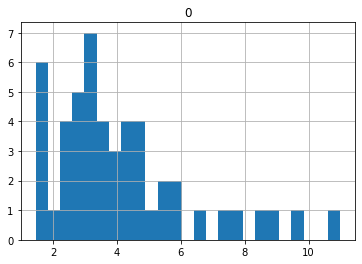

In [5]:
_ = pd.DataFrame(firms[:, 0]).hist(bins=int(args['n_firms']/2))

### Distribution of firm returns to scale

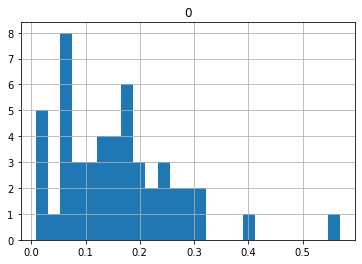

In [6]:
_ = pd.DataFrame(firms[:, 1]).hist(bins=int(args['n_firms']/2))

### Distrubution of firm fixed costs

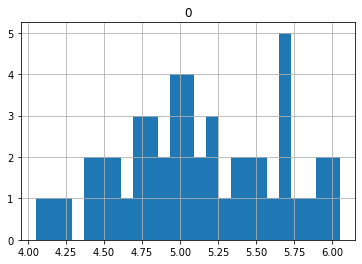

In [7]:
_ = pd.DataFrame(firms[:, 2]).hist(bins=int(args['n_firms']/2))

### Distribution of agent wealth (of asset 1)

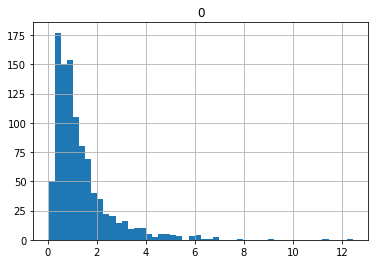

In [8]:
_ = pd.DataFrame(agents[:, 0]).hist(bins=int(args['n_agents']/20))

### Distribution of agent preferences (sigma)

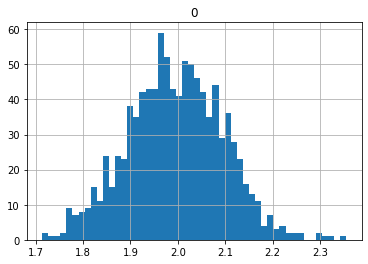

In [9]:
_ = pd.DataFrame(agents[:, -1]).hist(bins=int(args['n_agents']/20))

### Visual representation of equilibrium

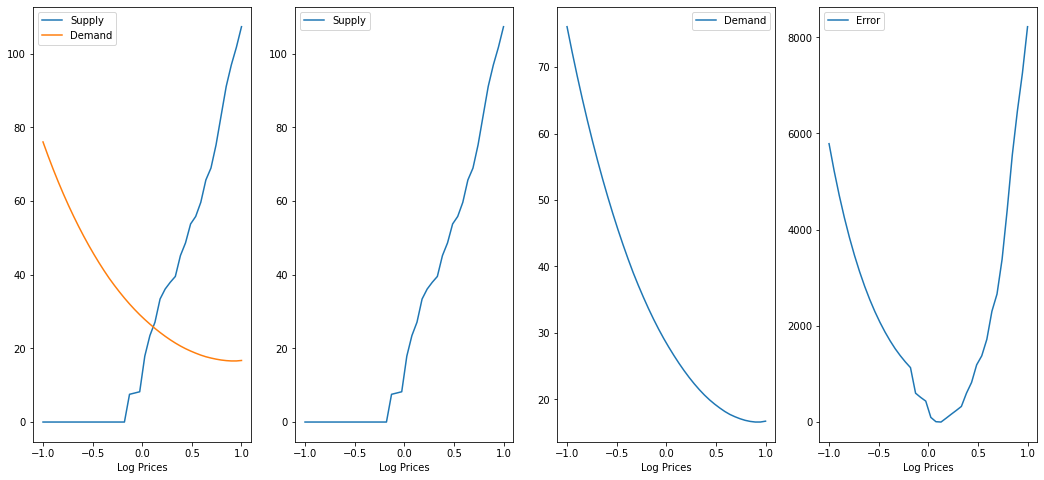

In [10]:
bins = 40
output_prices = jnp.linspace(-1, 1, bins)[:, jnp.newaxis]
input_prices = jnp.repeat(prices[1:][jnp.newaxis], bins, axis=0)
prices_mat = jnp.concatenate((output_prices, input_prices), axis=1)
s = jax.vmap(lambda p: supply(jnp.exp(p), firms))(prices_mat)
do = jax.vmap(lambda r, p: demand(r, jnp.exp(p), agents, n_goods, args['T']))(s[1], prices_mat)
errors = jax.vmap(e)(prices_mat)[:, jnp.newaxis]
so = s[0][:, 0][:, jnp.newaxis]

df = pd.DataFrame(jnp.concatenate([prices_mat[:, 0][:, jnp.newaxis], so, do, errors], axis=1))
df.columns = ['Log Prices', 'Supply', 'Demand', 'Error']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18,8))
_ = df.plot(x=0, y=[1, 2], ax=axes[0])
_ = df.plot(x=0, y=[1], ax=axes[1])
_ = df.plot(x=0, y=[2], ax=axes[2])
_ = df.plot(x=0, y=[3], ax=axes[3])

Note that the supply curve is quite lumpy because of fixed costs --- there are many breakpoints at which firms enter/leave production

If it looks like the equillibrium will fall in a reasonable area of the problem space, then let's search for it!

In [11]:
eql_log_prices = find_equilibrium_prices(*(args.values()))

iteration: 0
log_prices: [1. 1. 1.]
gradient: [-1266.8458    660.63245   706.67694]
error: 404.23602294921875
iteration: 10
log_prices: [1.0725107  0.93141776 0.9312145 ]
gradient: [ 345.28067 -191.66269 -196.9713 ]
error: 7.945450305938721
iteration: 20
log_prices: [1.0689331  0.93610615 0.93525416]
gradient: [ 290.79984 -162.7717  -166.0827 ]
error: 5.202483177185059
iteration: 30
log_prices: [1.0452751 0.9587797 0.9575181]
gradient: [-274.75818  165.6055   162.60774]
error: 2.123885154724121
iteration: 40
log_prices: [1.0472254  0.9588228  0.95642835]
gradient: [-223.29301  135.60658  129.87093]
error: 1.5012942552566528
iteration: 50
log_prices: [1.0572658  0.95145845 0.9479155 ]
gradient: [ 53.734684 -31.526072 -30.698236]
error: 0.12798774242401123
iteration: 60
log_prices: [1.0586842  0.95048934 0.9467283 ]
gradient: [ 81.7373   -47.826702 -46.586452]
error: 0.30804863572120667
iteration: 70
log_prices: [1.0551332  0.9532131  0.94972616]
gradient: [ 5.8127613 -3.434298  -3.32665

In [14]:
s = supply(jnp.exp(eql_log_prices), firms)
R = s[1]
assert not jnp.isnan(R)
d = demand(R, jnp.exp(eql_log_prices), agents, n_goods, args['T'])
err = e(eql_log_prices)
print(f'(Log) equilibrium prices: {eql_log_prices}\nSupply: {s[0][0]}\nDemand: {d[0]}\nTherefore, error: {err}')

(Log) equilibrium prices: [ 0.05342454 -0.04772192 -0.05136683]
Supply: 25.875282287597656
Demand: 25.875282287597656
Therefore, error: 0.0
